In [1]:
from google.colab import drive

drive.mount('/content/drive/',  force_remount=True)

Mounted at /content/drive/


In [2]:
!unzip /content/drive/MyDrive/dataset.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005002.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005003.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005004.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005005.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005006.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005007.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005008.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005009.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005010.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005011.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005012.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005013.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005014.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005015.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_0000

In [3]:
import os
import pandas as pd
from PIL import Image

In [4]:
data = {'img':[], 'label':[], }
path = '/content/dataset'
folder = os.listdir(path)
class_name = {'real':0, 'StyleGAN':1, 'StyleGAN2':2}

for target in folder:
  images = os.listdir(path +'/'+target)
  cnt = 0
  for image in images:
    data['img'].append(Image.open(path +'/'+target + '/' +image))
    data['label'].append(class_name[target])
    cnt += 1
    if cnt == 5000:
      break

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['img'], data['label'], test_size=0.20, random_state=42, shuffle=True)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, shuffle=True)

In [7]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
import numpy as np
import matplotlib.pyplot as plt

class MyDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [8]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

normalize = Normalize(mean=means, std=stds)
_train_transforms = Compose(
        [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(224),
            CenterCrop(224),
            ToTensor(),
            normalize,
        ]
    )

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import random

In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [11]:
model_vgg = models.vgg16(weights='DEFAULT')
num_features = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = torch.nn.Linear(num_features, 3)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 140MB/s]


In [12]:
model_vgg = model_vgg.to('cuda')

In [13]:
model_path = '/content/drive/MyDrive/model/vgg16_state_dict.pth'
model_vgg.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [14]:
optimizer = optim.AdamW(model_vgg.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [15]:
test_set = MyDataset(X_test,y_test, transform=_val_transforms)
testloader = DataLoader(test_set, batch_size=1)

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

def test_model(model, dataloader, criterion, show_images=False, num_images=10):
    name_lookup = {v: k for k, v in class_name.items()}

    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_labels = []
    incorrect_samples = []
    incorrect_count = 0


    # No need to track gradients for testing
    with torch.no_grad():
        for inputs, labels in dataloader:

            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Collect incorrect samples
            misclassified_indices = (preds != labels).nonzero().flatten()
            incorrect_count += len(misclassified_indices)
            for index in misclassified_indices:
                incorrect_samples.append((inputs[index], labels[index].item(), preds[index].item()))

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Test Loss: {total_loss / total_samples:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print(f'Incorrectly Labeled: {incorrect_count}/{total_samples} ({incorrect_count/total_samples*100:.2f}%)')

    if show_images and incorrect_samples:
        num_columns = 5  # Set the number of columns for the grid
        num_rows = (num_images + num_columns - 1) // num_columns  # Calculate the required number of rows
        fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))  # Adjust the figure size appropriately
        for i, (img, true, pred) in enumerate(incorrect_samples[:num_images]):
            ax = axes[i // num_columns, i % num_columns]
            img = img.cpu().numpy().transpose((1, 2, 0))
            img = np.clip(img, 0, 1)
            ax.imshow(img, interpolation='nearest')
            ax.set_title(f'True: {name_lookup[true]},\nPred: {name_lookup[pred]}')
            ax.axis('off')

    return total_loss / total_samples, precision, recall, f1, all_labels, all_preds

In [21]:
test_loss, test_precision, test_recall, test_f1, true_labels, predictions = test_model(model_vgg, testloader, criterion, show_images=True, num_images=15)

Test Loss: 0.0914
Precision: 0.9642, Recall: 0.9644, F1 Score: 0.9642
Incorrectly Labeled: 109/3000 (3.63%)


In [27]:
import seaborn as sns

def plot_confusion_matrix(true_labels, predictions, class_names=None):

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    print(classification_report(true_labels, predictions))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", cbar=True,  # 'd' for decimal format
                xticklabels=class_names if class_names else np.unique(true_labels),
                yticklabels=class_names if class_names else np.unique(true_labels))

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1037
           1       0.93      0.96      0.95       993
           2       1.00      1.00      1.00       970

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



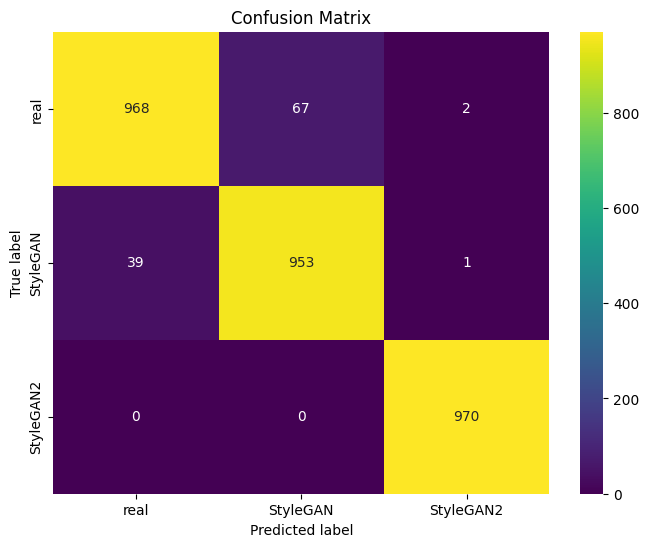

In [28]:
plot_confusion_matrix(true_labels, predictions, class_names=['real', 'StyleGAN', 'StyleGAN2'])

In [36]:
def predict_image(model, image_path, true_label):
  model.eval()
  image = Image.open(image_path)
  X_test = [image]
  y_test = [true_label]
  test_set = MyDataset(X_test,y_test, transform=_val_transforms)
  testloader = DataLoader(test_set, batch_size=1)
  with torch.no_grad():
    for inputs, labels in testloader:
      inputs = inputs.to('cuda')
      labels = labels.to('cuda')
      logits = model(inputs)
      _, preds = torch.max(logits, 1)
      if preds == 2:
        preds = 1

  return preds

In [37]:
path = "/content/drive/MyDrive/ai and human faces/"
folder = os.listdir(path)

Accuracy: 22/24 = 91.67%


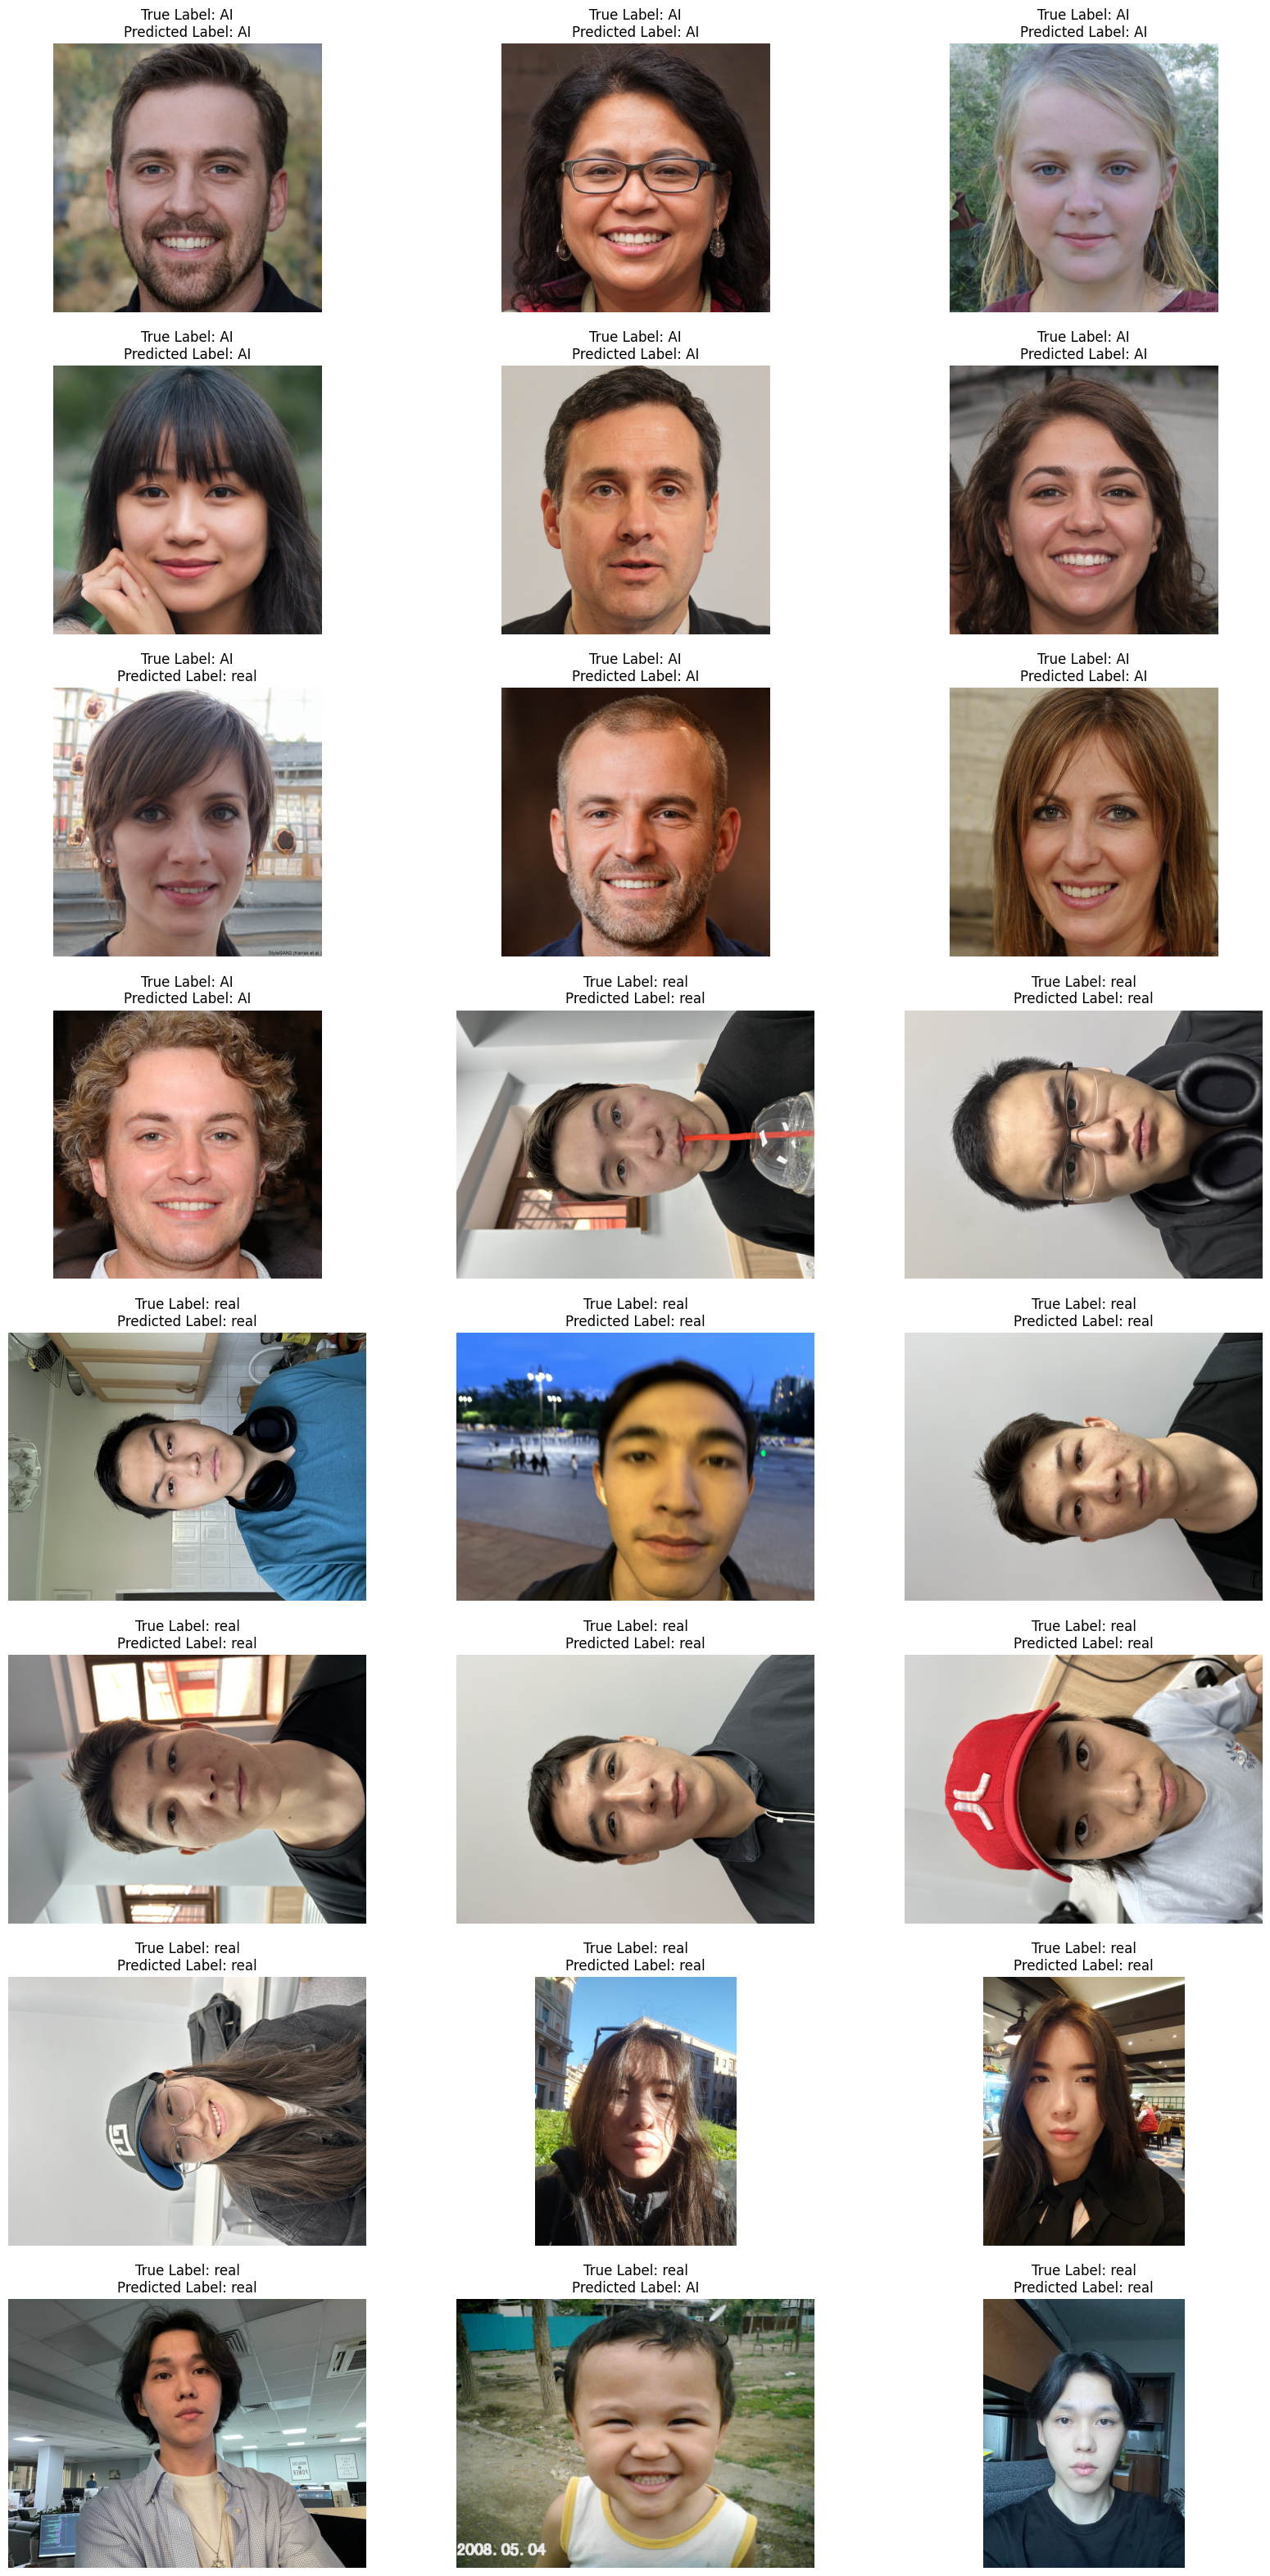

In [47]:
num_images = len(folder)
num_cols = 3
num_rows = (num_images // num_cols) + (num_images % num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))

true_labels_faces = []
predictions_faces = []

for i, ax in enumerate(axes.flat):
    if i < num_images:
        image_path = os.path.join(path, folder[i])
        true_label = 0 if 'human' in folder[i] else 1
        prediction = predict_image(model_vgg, image_path, true_label)

        true_labels_faces.append(true_label)
        predictions_faces.append(prediction)

        # Load and display image
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')

        ax.set_title(f"True Label: {'real' if true_label == 0 else 'AI'}\nPredicted Label: {'real' if prediction == 0 else 'AI'}")

def calculate_accuracy(labels, predictions):
    correct = sum(1 for true, pred in zip(labels, predictions) if true == pred)
    total = len(labels)
    accuracy = correct / total
    print(f"Accuracy: {correct}/{total} = {accuracy * 100:.2f}%")

calculate_accuracy(true_labels_faces, predictions_faces)

plt.show()